In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import random

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 12
IMG_SIZE = (64, 64)
NUM_CLASSES = 10


In [5]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip


--2026-02-15 14:23:21--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2026-02-15 14:23:21--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  13.2MB/s    in 18s     

2026-02-15 14:23:40 (12.9 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [15]:
train_dir = "tiny-imagenet-200/train"
class_names = sorted(os.listdir(train_dir))[:10]

def get_image_paths():
    image_paths = []
    labels = []

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name, "images")
        images = os.listdir(class_path)
        for img in images:
            image_paths.append(os.path.join(class_path, img))
            labels.append(idx)

    return image_paths, labels

image_paths, labels = get_image_paths()


In [16]:
def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.shuffle(10000)
dataset = dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [17]:
from tensorflow.keras import layers, models

def build_model(use_batchnorm=False):
    inputs = layers.Input(shape=(64, 64, 3))
    x = inputs

    x = layers.Conv2D(32, 3, padding='same')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding='same', name="conv5")(x)
    if use_batchnorm:
        x = layers.BatchNormalization(name="bn5")(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 3, padding='same')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [18]:
model_no_bn = build_model(use_batchnorm=False)
model_bn = build_model(use_batchnorm=True)

for model in [model_no_bn, model_bn]:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


In [19]:
model_bn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 16, 16, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 1,132,106 (4.32 MB)

 Trainable params: 1,130,378 (4.31 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [20]:
EPOCHS = 10

print("Training without BatchNorm")
model_no_bn.fit(dataset, epochs=EPOCHS)

print("Training with BatchNorm")
model_bn.fit(dataset, epochs=EPOCHS)


Training without BatchNorm
Epoch 1/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.0947 - loss: 2.3107
Epoch 2/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1287 - loss: 2.2897
Epoch 3/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1046 - loss: 2.3029
Epoch 4/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0951 - loss: 2.3031
Epoch 5/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0997 - loss: 2.3030
Epoch 6/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1028 - loss: 2.3032
Epoch 7/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0942 - loss: 2.2948
Epoch 8/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1207 - loss: 2.2889
Epoch 9/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1007 - loss: 2.3009
Epoch 10/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1038 - loss: 2.2995
Training with BatchNorm
Epoch 1/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.2617 - lo

In [21]:
def collect_stats(model, layer_name, dataset, num_batches=500):

    intermediate_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output
    )

    means = []
    variances = []

    batch_count = 0

    for images, _ in dataset:
        activations = intermediate_model(images, training=False)
        activations = activations.numpy()

        means.append(np.mean(activations))
        variances.append(np.var(activations))

        batch_count += 1
        if batch_count >= num_batches:
            break

    return means, variances


In [22]:
means_no_bn, vars_no_bn = collect_stats(model_no_bn, "conv5", dataset)


In [23]:
means_bn, vars_bn = collect_stats(model_bn, "bn5", dataset)


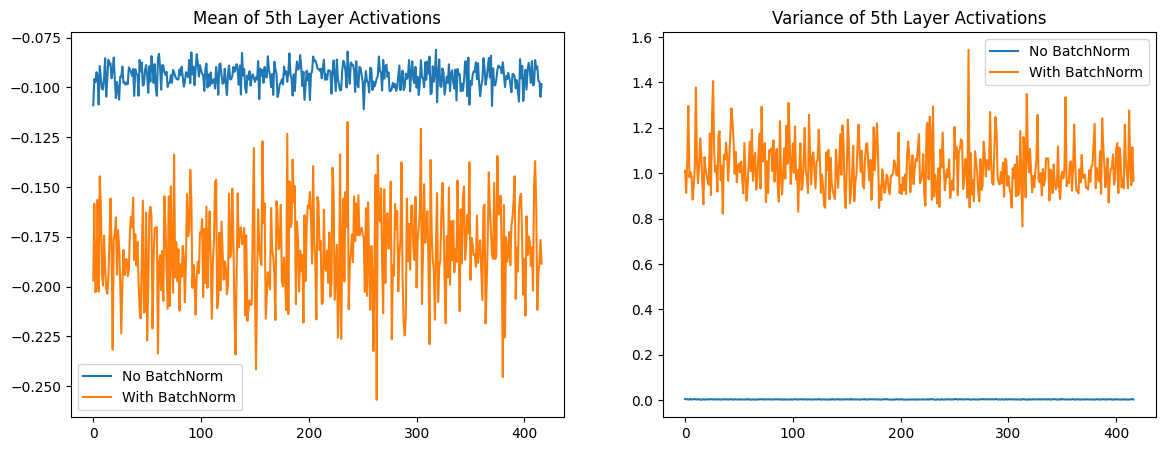

In [24]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(means_no_bn, label="No BatchNorm")
plt.plot(means_bn, label="With BatchNorm")
plt.title("Mean of 5th Layer Activations")
plt.legend()

plt.subplot(1,2,2)
plt.plot(vars_no_bn, label="No BatchNorm")
plt.plot(vars_bn, label="With BatchNorm")
plt.title("Variance of 5th Layer Activations")
plt.legend()

plt.show()


### 4.2 Data Augmentation

In [25]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

train_dataset_no_aug = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))

train_dataset_no_aug = train_dataset_no_aug.map(preprocess, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

train_dataset_no_aug = train_dataset_no_aug.shuffle(10000)
train_dataset_no_aug = train_dataset_no_aug.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [26]:
from tensorflow.keras.layers import RandomRotation, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomRotation(factor=30/360.0),
    RandomContrast(factor=0.05)
])

def augment_and_preprocess(path, label):
    image, label = preprocess(path, label)
    image = data_augmentation(image, training=True)
    return image, label



AUGMENT_FACTOR = 5

train_dataset_aug = tf.data.Dataset.from_tensor_slices(
    (train_image_paths, train_labels)
)

train_dataset_aug = train_dataset_aug.repeat(AUGMENT_FACTOR)

train_dataset_aug = train_dataset_aug.map(
    augment_and_preprocess,
    num_parallel_calls=AUTOTUNE
)

train_dataset_aug = train_dataset_aug.shuffle(10000)
train_dataset_aug = train_dataset_aug.batch(BATCH_SIZE)
train_dataset_aug = train_dataset_aug.prefetch(AUTOTUNE)


In [27]:
model_no_aug_bn = build_model(use_batchnorm=True)
model_aug_bn = build_model(use_batchnorm=True)

for model in [model_no_aug_bn, model_aug_bn]:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', 'sparse_categorical_crossentropy']
    )

print("Training model with augmentation...")
history_aug_bn = model_aug_bn.fit(train_dataset_aug, epochs=EPOCHS)

print("Training model without augmentation...")
history_no_aug_bn = model_no_aug_bn.fit(train_dataset_no_aug, epochs=EPOCHS)


Training model with augmentation...
Epoch 1/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.3157 - loss: 1.9492 - sparse_categorical_crossentropy: 1.9492
Epoch 2/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.4983 - loss: 1.4722 - sparse_categorical_crossentropy: 1.4722
Epoch 3/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.5889 - loss: 1.2068 - sparse_categorical_crossentropy: 1.2068
Epoch 4/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.6526 - loss: 1.0172 - sparse_categorical_crossentropy: 1.0172
Epoch 5/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.7040 - loss: 0.8738 - sparse_categorical_crossentropy: 0.8738
Epoch 6/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.7559 - loss: 0.7264 - sparse_categorical_crossentropy: 0.7264
Epoch 7/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.7892 - loss: 0.6241 - sparse_categorical_crossentropy: 0.6241
Epoch 8/10
1667/1667 ━━━━━━━━━━━━━━━━━━━

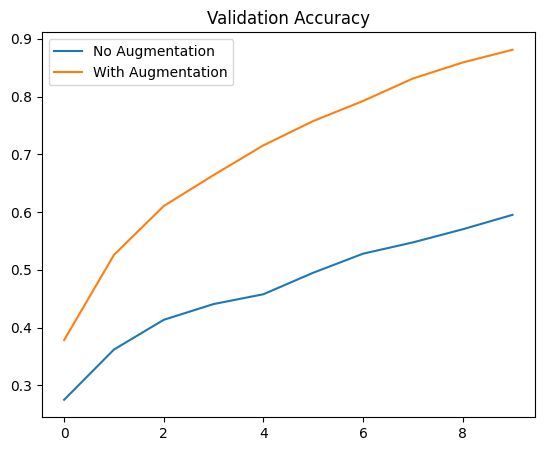

In [28]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_no_aug_bn.history["accuracy"], label="No Augmentation")
plt.plot(history_aug_bn.history["accuracy"], label="With Augmentation")
plt.title("Validation Accuracy")
plt.legend()
plt.show()


In [30]:
print("Models Evaluation:")
loss_no_aug_bn, accuracy_no_aug_bn, _ = model_no_aug_bn.evaluate(test_dataset)
print(f"Test Accuracy (No Augmentation): {accuracy_no_aug_bn:.4f}")

loss_aug_bn, accuracy_aug_bn,_ = model_aug_bn.evaluate(test_dataset)
print(f"Test Accuracy (With Augmentation): {accuracy_aug_bn:.4f}")

Models Evaluation:
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4749 - loss: 1.7346 - sparse_categorical_crossentropy: 1.7346
Test Accuracy (No Augmentation): 0.4670
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5789 - loss: 1.9297 - sparse_categorical_crossentropy: 1.9297
Test Accuracy (With Augmentation): 0.5810
